# UFC 경기 승패 예측: 스태킹 모델 (최종 수정본)

이 노트북은 UFC 경기 데이터를 사용하여 스태킹 모델을 구축하고, 두 선수 간의 승률을 예측합니다. 이전 버전의 모든 오류를 수정하고 코드의 안정성과 정확성을 높였습니다.

**주요 개선 사항:**
1. **정확한 데이터 처리**: 실제 CSV의 컬럼 구조에 맞춰 데이터를 로드하고, 컬럼명 처리 로직을 수정하여 데이터 왜곡을 방지했습니다.
2. **완벽한 결측치 제어**: 선수별 스탯 DB를 만들기 전에 모든 결측치를 처리하여 `Null` 값 문제를 완전히 해결했습니다.
3. **안정적인 특성 관리**: 학습과 예측에 사용되는 특성 목록을 일치시켜 `KeyError`를 원천적으로 차단했습니다.

## 1. 라이브러리 임포트 및 데이터 로드

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import BorderlineSMOTE # BorderlineSMOTE 임포트
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

## 2. 데이터 클리닝 및 전처리

In [125]:
df = pd.read_csv('UFC.csv')

# 1. 필수 컬럼 결측치 행 제거
df.dropna(subset=['winner', 'r_dob', 'b_dob', 'r_height', 'b_height', 'r_weight', 'b_weight'], inplace=True)

# 2. Reach 결측치를 Height로 대체
df['r_reach'].fillna(df['r_height'], inplace=True)
df['b_reach'].fillna(df['b_height'], inplace=True)

# 3. 모든 수치형 컬럼의 나머지 결측치를 0으로 채우기
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols] = df[numeric_cols].fillna(0)

# 4. 날짜 변환 및 나이 계산
df['r_dob'] = pd.to_datetime(df['r_dob'])
df['b_dob'] = pd.to_datetime(df['b_dob'])
df['r_age'] = (pd.to_datetime('today') - df['r_dob']).dt.days / 365.25
df['b_age'] = (pd.to_datetime('today') - df['b_dob']).dt.days / 365.25

print('데이터 클리닝 및 전처리 완료')

데이터 클리닝 및 전처리 완료


In [126]:
# 필요한 컬럼만 선택
fighter_cols = ['wins', 'losses', 'draws', 'height', 'weight', 'reach', 'dob']
r_cols = ['r_' + col for col in fighter_cols]
b_cols = ['b_' + col for col in fighter_cols]
stat_cols = ['splm', 'str_acc', 'sapm', 'str_def', 'td_avg', 'td_avg_acc', 'td_def', 'sub_avg']
r_stat_cols = ['r_' + col for col in stat_cols]
b_stat_cols = ['b_' + col for col in stat_cols]

In [127]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7902 entries, 0 to 8237
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   r_name         7902 non-null   object        
 1   r_wins         7902 non-null   int64         
 2   r_losses       7902 non-null   int64         
 3   r_draws        7902 non-null   int64         
 4   r_height       7902 non-null   float64       
 5   r_weight       7902 non-null   float64       
 6   r_reach        7902 non-null   float64       
 7   r_dob          7902 non-null   datetime64[ns]
 8   r_splm         7902 non-null   float64       
 9   r_str_acc      7902 non-null   int64         
 10  r_sapm         7902 non-null   float64       
 11  r_str_def      7902 non-null   int64         
 12  r_td_avg       7902 non-null   float64       
 13  r_td_avg_acc   7902 non-null   int64         
 14  r_td_def       7902 non-null   int64         
 15  r_sub_avg      7902 non-nu

## 3. 선수별 고유 스탯 데이터베이스 구축

In [128]:
# Red, Blue 선수 스탯을 각각 분리
r_stats = df[[col for col in df.columns if col.startswith('r_')]].copy()
b_stats = df[[col for col in df.columns if col.startswith('b_')]].copy()

# 컬럼명에서 접두사('r_', 'b_')를 정확히 제거
r_stats.columns = [col[2:] for col in r_stats.columns]
b_stats.columns = [col[2:] for col in b_stats.columns]

# 두 데이터프레임을 하나로 통합하고, 첫 등장 스탯만 사용
all_fighters = pd.concat([r_stats, b_stats], ignore_index=True)
unique_fighters = all_fighters.drop_duplicates(subset=['name'], keep='first')
fighter_stats_df = unique_fighters.set_index('name')

print('선수별 고유 스탯 데이터베이스 생성 완료!')
fighter_stats_df.info()

선수별 고유 스탯 데이터베이스 생성 완료!
<class 'pandas.core.frame.DataFrame'>
Index: 2419 entries, Tofiq Musayev to Patrick Smith
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   wins        2419 non-null   int64         
 1   losses      2419 non-null   int64         
 2   draws       2419 non-null   int64         
 3   height      2419 non-null   float64       
 4   weight      2419 non-null   float64       
 5   reach       2419 non-null   float64       
 6   dob         2419 non-null   datetime64[ns]
 7   splm        2419 non-null   float64       
 8   str_acc     2419 non-null   int64         
 9   sapm        2419 non-null   float64       
 10  str_def     2419 non-null   int64         
 11  td_avg      2419 non-null   float64       
 12  td_avg_acc  2419 non-null   int64         
 13  td_def      2419 non-null   int64         
 14  sub_avg     2419 non-null   float64       
 15  age         2419 non-null   floa

## 4. 특성 공학

In [129]:
# [전처리] 불필요 컬럼 제거 및 결측치 처리
df.dropna(subset=['winner', 'r_dob', 'b_dob', 'r_height', 'b_height', 'r_weight', 'b_weight'], inplace=True)
df['r_reach'].fillna(df['r_height'], inplace=True)
df['b_reach'].fillna(df['b_height'], inplace=True)

# [특성 공학] 타겟 변수 및 파생 변수 생성
df['winner_is_red'] = (df['winner'] == df['r_name']).astype(int)
df['r_dob'] = pd.to_datetime(df['r_dob'])
df['b_dob'] = pd.to_datetime(df['b_dob'])
df['r_age'] = (pd.to_datetime('today') - df['r_dob']).dt.days / 365.25
df['b_age'] = (pd.to_datetime('today') - df['b_dob']).dt.days / 365.25

# 차이 특성
df['age_diff'] = df['r_age'] - df['b_age']
df['height_diff'] = df['r_height'] - df['b_height']
df['weight_diff'] = df['r_weight'] - df['b_weight']
df['reach_diff'] = df['r_reach'] - df['b_reach']
df['wins_diff'] = df['r_wins'] - df['b_wins']
df['losses_diff'] = df['r_losses'] - df['b_losses']
df['splm_diff'] = df['r_splm'] - df['b_splm']
df['str_acc_diff'] = df['r_str_acc'] - df['b_str_acc']
df['sapm_diff'] = df['r_sapm'] - df['b_sapm']
df['str_def_diff'] = df['r_str_def'] - df['b_str_def']
df['td_avg_diff'] = df['r_td_avg'] - df['b_td_avg']
df['td_avg_acc_diff'] = df['r_td_avg_acc'] - df['b_td_avg_acc']
df['td_def_diff'] = df['r_td_def'] - df['b_td_def']
df['sub_avg_diff'] = df['r_sub_avg'] - df['b_sub_avg']

# 비율 및 복합 특성
# ratio features (0~1 scaled)
df['sig_str_ratio'] = df['r_splm'] / (df['r_splm'] + df['b_splm'] + 1e-6)
df['td_ratio'] = df['r_td_avg'] / (df['r_td_avg'] + df['b_td_avg'] + 1e-6)
df['str_acc_ratio'] = df['r_str_acc'] / (df['r_str_acc'] + df['b_str_acc'] + 1e-6)
df['td_acc_ratio'] = df['r_td_avg_acc'] / (df['r_td_avg_acc'] + df['b_td_avg_acc'] + 1e-6)

# win ratio features
df['r_win_ratio'] = df['r_wins'] / (df['r_wins'] + df['r_losses'] + 1e-6)
df['b_win_ratio'] = df['b_wins'] / (df['b_wins'] + df['b_losses'] + 1e-6)
df['win_ratio_diff'] = df['r_win_ratio'] - df['b_win_ratio']

# ---------- 추가 파생 특성 ----------
# BMI
df['r_bmi'] = df['r_weight'] / ((df['r_height'] / 100) ** 2 + 1e-6)
df['b_bmi'] = df['b_weight'] / ((df['b_height'] / 100) ** 2 + 1e-6)
df['bmi_diff'] = df['r_bmi'] - df['b_bmi']

# 총 경기 수
df['r_total_fights'] = df['r_wins'] + df['r_losses']
df['b_total_fights'] = df['b_wins'] + df['b_losses']
df['total_fights_diff'] = df['r_total_fights'] - df['b_total_fights']

# ---------- 추가 파생 특성 v3 ----------
# 1) 공격 점수: Striking + Grappling 효율 합
df['r_offense_score'] = df['r_str_eff'] + df['r_grap_eff'] if 'r_str_eff' in df.columns else \
                        (df['r_splm'] * df['r_str_acc']) + (df['r_td_avg'] * df['r_td_avg_acc'])
df['b_offense_score'] = df['b_str_eff'] + df['b_grap_eff'] if 'b_str_eff' in df.columns else \
                        (df['b_splm'] * df['b_str_acc']) + (df['b_td_avg'] * df['b_td_avg_acc'])
df['offense_score_diff'] = df['r_offense_score'] - df['b_offense_score']

# 2) 방어 점수: 타격·테이크다운 방어율 평균
df['r_defense_score'] = (df['r_str_def'] + df['r_td_def']) / 2
df['b_defense_score'] = (df['b_str_def'] + df['b_td_def']) / 2
df['defense_score_diff'] = df['r_defense_score'] - df['b_defense_score']

# 3) 순공격 이득(Net Advantage) = 공격 diff + 방어 diff
df['net_advantage'] = df['offense_score_diff'] + df['defense_score_diff']

# 4) 상호작용 특성: 레드의 공격 vs 블루의 방어, 블루의 공격 vs 레드의 방어
df['str_vs_def_diff'] = (df['r_str_acc'] * df['b_str_def']) - (df['b_str_acc'] * df['r_str_def'])

# 5) 공격/방어 스코어 비율 차이
df['off_def_ratio_diff'] = (df['r_offense_score'] / (df['r_defense_score'] + 1e-6)) - \
                           (df['b_offense_score'] / (df['b_defense_score'] + 1e-6))


In [130]:
df['winner_is_red'].groupby(df['winner_is_red']).count()

winner_is_red
0    2860
1    5042
Name: winner_is_red, dtype: int64

## 5. 스태킹 모델 학습 및 평가

In [131]:
# 학습에 사용할 최종 특성 리스트를 명확하게 정의
final_features = [
    'age_diff', 'height_diff', 'weight_diff', 'reach_diff', 'wins_diff', 'losses_diff',
    'splm_diff', 'str_acc_diff', 'sapm_diff', 'str_def_diff', 'td_avg_diff', 
    'td_avg_acc_diff', 'td_def_diff', 'sub_avg_diff', 'sig_str_ratio', 'td_ratio',
    'str_acc_ratio', 'td_acc_ratio', 'win_ratio_diff', 'bmi_diff', 'total_fights_diff',
    'offense_score_diff', 'defense_score_diff', 'net_advantage', 'str_vs_def_diff',
    'off_def_ratio_diff'
]

X = df[final_features]
y = df['winner_is_red']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# RandomizedSearchCV로 찾은 최적 파라미터를 적용
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=-1)),
    ('lgb', LGBMClassifier(n_estimators=200, learning_rate=0.05, num_leaves=31, random_state=42, verbose=-1, n_jobs=-1)),
    ('xgb', xgb.XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric='logloss'))
]

# 2. BorderlineSMOTE를 적용한 파이프라인 구축
stacking_pipeline = ImbPipeline([
    ('smote', BorderlineSMOTE(random_state=42)), # 3. BorderlineSMOTE 적용
    ('scaler', StandardScaler()),
    ('classifier', StackingClassifier(
        estimators=estimators,
        final_estimator=GradientBoostingClassifier(random_state=42), # final_estimator 변경
        cv=5,
        n_jobs=-1
    ))
])

In [132]:
print('--- 최적화된 스태킹 모델 학습 시작 ---')
stacking_pipeline.fit(X_train, y_train)
print('--- 스태킹 모델 학습 완료 ---')

--- 최적화된 스태킹 모델 학습 시작 ---
--- 스태킹 모델 학습 완료 ---



정확도: 0.7198
ROC-AUC: 0.7774
분류 보고서: 
               precision    recall  f1-score   support

           0       0.61      0.64      0.62       572
           1       0.79      0.77      0.78      1009

    accuracy                           0.72      1581
   macro avg       0.70      0.70      0.70      1581
weighted avg       0.72      0.72      0.72      1581



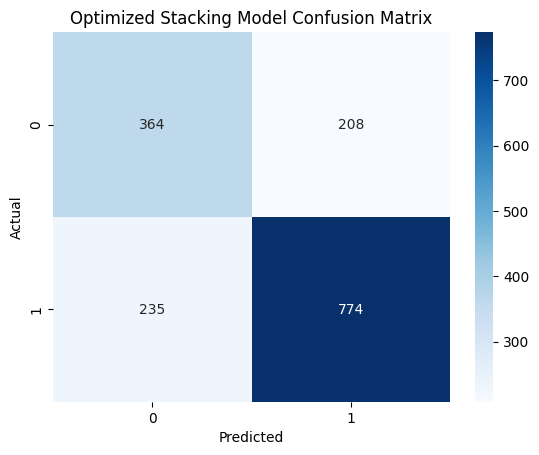

In [133]:
# 모델 평가
y_pred_proba = stacking_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print(f'\n정확도: {accuracy_score(y_test, y_pred):.4f}')
print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}')
print('분류 보고서:','\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Optimized Stacking Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6. 임의의 두 선수 간 승률 예측 함수

In [138]:
def predict_win_probability(fighter1_name, fighter2_name, fighter_db, model, features_list):
    try:
        fighter1_stats = fighter_db.loc[fighter1_name].fillna(0)
        fighter2_stats = fighter_db.loc[fighter2_name].fillna(0)
    except KeyError as e:
        return f'선수 데이터를 찾을 수 없습니다: {e.args[0]}'
    
    # 두 선수의 스탯을 기반으로 모든 파생 특성을 계산
    matchup_data = {}
    matchup_data['age_diff'] = fighter1_stats['age'] - fighter2_stats['age']
    matchup_data['height_diff'] = fighter1_stats['height'] - fighter2_stats['height']
    matchup_data['weight_diff'] = fighter1_stats['weight'] - fighter2_stats['weight']
    matchup_data['reach_diff'] = fighter1_stats['reach'] - fighter2_stats['reach']
    matchup_data['wins_diff'] = fighter1_stats['wins'] - fighter2_stats['wins']
    matchup_data['losses_diff'] = fighter1_stats['losses'] - fighter2_stats['losses']
    matchup_data['splm_diff'] = fighter1_stats['splm'] - fighter2_stats['splm']
    matchup_data['str_acc_diff'] = fighter1_stats['str_acc'] - fighter2_stats['str_acc']
    matchup_data['sapm_diff'] = fighter1_stats['sapm'] - fighter2_stats['sapm']
    matchup_data['str_def_diff'] = fighter1_stats['str_def'] - fighter2_stats['str_def']
    matchup_data['td_avg_diff'] = fighter1_stats['td_avg'] - fighter2_stats['td_avg']
    matchup_data['td_avg_acc_diff'] = fighter1_stats['td_avg_acc'] - fighter2_stats['td_avg_acc']
    matchup_data['td_def_diff'] = fighter1_stats['td_def'] - fighter2_stats['td_def']
    matchup_data['sub_avg_diff'] = fighter1_stats['sub_avg'] - fighter2_stats['sub_avg']

    matchup_data['sig_str_ratio'] = fighter1_stats['splm'] / (fighter1_stats['splm'] + fighter2_stats['splm'] + 1e-6)
    matchup_data['td_ratio'] = fighter1_stats['td_avg'] / (fighter1_stats['td_avg'] + fighter2_stats['td_avg'] + 1e-6)
    matchup_data['str_acc_ratio'] = fighter1_stats['str_acc'] / (fighter1_stats['str_acc'] + fighter2_stats['str_acc'] + 1e-6)
    matchup_data['td_acc_ratio'] = fighter1_stats['td_avg_acc'] / (fighter1_stats['td_avg_acc'] + fighter2_stats['td_avg_acc'] + 1e-6)

    matchup_data['win_ratio_diff'] = (fighter1_stats['wins'] / (fighter1_stats['wins'] + fighter1_stats['losses'] + 1e-6)) - (fighter2_stats['wins'] / (fighter2_stats['wins'] + fighter2_stats['losses'] + 1e-6))
    matchup_data['bmi_diff'] = (fighter1_stats['weight'] / ((fighter1_stats['height'] / 100) ** 2 + 1e-6)) - (fighter2_stats['weight'] / ((fighter2_stats['height'] / 100) ** 2 + 1e-6))
    matchup_data['total_fights_diff'] = (fighter1_stats['wins'] + fighter1_stats['losses']) - (fighter2_stats['wins'] + fighter2_stats['losses'])

    f1_offense_score = (fighter1_stats['splm'] * fighter1_stats['str_acc']) + (fighter1_stats['td_avg'] * fighter1_stats['td_avg_acc'])
    f2_offense_score = (fighter2_stats['splm'] * fighter2_stats['str_acc']) + (fighter2_stats['td_avg'] * fighter2_stats['td_avg_acc'])
    matchup_data['offense_score_diff'] = f1_offense_score - f2_offense_score

    f1_defense_score = (fighter1_stats['str_def'] + fighter1_stats['td_def']) / 2
    f2_defense_score = (fighter2_stats['str_def'] + fighter2_stats['td_def']) / 2
    matchup_data['defense_score_diff'] = f1_defense_score - f2_defense_score

    matchup_data['net_advantage'] = matchup_data['offense_score_diff'] + matchup_data['defense_score_diff']
    matchup_data['str_vs_def_diff'] = (fighter1_stats['str_acc'] * fighter2_stats['str_def']) - (fighter2_stats['str_acc'] * fighter1_stats['str_def'])
    matchup_data['off_def_ratio_diff'] = (f1_offense_score / (f1_defense_score + 1e-6)) - (f2_offense_score / (f2_defense_score + 1e-6))

    matchup_df = pd.DataFrame([matchup_data])[features_list]
    
    # 승리 확률 예측
    win_proba = model.predict_proba(matchup_df)[0, 1]
    
    print(f'경기 예측: {fighter1_name} vs {fighter2_name}')
    print(f'{fighter1_name}의 승리 확률: {win_proba*100:.2f}%')
    print(f'{fighter2_name}의 승리 확률: {(1-win_proba)*100:.2f}%')

## 7. 예측 예시

In [141]:
# 예시: 'Dooho Choi' vs 'Chan Sung Jung'
predict_win_probability('Dooho Choi', 'Chan Sung Jung', fighter_stats_df, best_model, final_features)

print('-'*50 + '')

# 예시 2: 'Dong Hyun Kim' vs 'Kyung Ho Kang'
predict_win_probability('Kyung Ho Kang', 'Dong Hyun Kim', fighter_stats_df, best_model, final_features)

경기 예측: Dooho Choi vs Chan Sung Jung
Dooho Choi의 승리 확률: 88.67%
Chan Sung Jung의 승리 확률: 11.33%
--------------------------------------------------
경기 예측: Kyung Ho Kang vs Dong Hyun Kim
Kyung Ho Kang의 승리 확률: 38.47%
Dong Hyun Kim의 승리 확률: 61.53%
